# Tarea 2. NN with LMS, Problema 1

## Fundamentos de inteligencia computacional
## por: Juan Pablo Arango A. & Simón Zapata Caro

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from pydoc import help  # can type in the python console `help(name of function)` to get the documentation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats
from IPython.display import display, HTML
from pandas.tools.plotting import scatter_matrix
from matplotlib.artist import setp
import time

plt.rcParams['figure.figsize'] = (10,16)

In [2]:
df1     = pd.io.excel.read_excel("DatosPunto1.xlsx", sheetname=0)
labels = df1.iloc[:,-2].copy()
df1 = df1.iloc[:,0:-2].copy()

X = np.array(df1)
y = np.array(labels)
X_original = X
y_original = y

In [3]:
def derivating(fx):
    difcoefs = [1,-1]
    return np.convolve(fx,difcoefs,mode='same')

def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out

def clearList(L): #arroja una lista de L elementos vacios, no sabia de qué otra forma hacerla
    listica = []
    for i in range(0,L):
        listica.append([]);
    return listica

def LMS_training(X,y,iteraciones=500,alpha=0.1,de_min=0.01):
    
    w_          = np.random.rand(X.shape[1] + 1,)
    n           = X.shape[0]
    nf          = X.shape[1]
    sw          = 0
    j           = 0
    index       = []
    error_array = []
    

    while j < iteraciones and sw == 0:
        for i in range(0,n):
            g  = np.dot(w_,np.insert(X[i,:],0,1).T)
            e  = g - y[i]
            w_ = w_ - alpha*e*np.insert(X[i,:],0,1)
        predicted = []
        for i in range(0,n):
            predicted.append(Predict(X[i,:],w_))
        g = (y-predicted)
        E = 0.5*np.sum(g*g.T)/y.shape[0]
        
        index.append(j)
        error_array.append(E)
        d_error_array = derivating(error_array)
        
        if np.abs(d_error_array[len(d_error_array)-1]) < de_min:
            sw = 1
        
        j = j + 1
    #print('Función de error: '+str(E)+' iterando ' +str(j)+' veces, con alpha: '+str(alpha))
    
    return [w_,predicted,E,j]

def Predict(X,w_): 
    return np.dot(w_,np.insert(X,0,1).T)


In [4]:
Nsamples = X.shape[0]
Ntrain   = int(0.7*Nsamples)
Nval     = int(0.15*Nsamples)
Ntest    = Nsamples-Ntrain-Nval

X_test = X[(Nsamples-Ntest):Nsamples,:]
y_test = y[(Nsamples-Ntest):Nsamples  ]

Xv = X[0:(Nsamples-Ntest),:]
yv = y[0:(Nsamples-Ntest)  ]

minimo    = np.min(X,axis=0)
maximo    = np.max(X,axis=0)
print(minimo.shape,maximo.shape)

(8,) (8,)


### Entrenamiento de la red neuronal usando validación bootstraping para $\alpha = logspace(10^{-5}, 0.5=10^{-0.30102}, N = 30)$

In [5]:
intentos  = 10
alpha     = np.logspace(-5,-0.30102,num=30)
ecm_train = np.zeros((intentos,len(alpha)))
ecm_val   = np.zeros((intentos,len(alpha)))

Xv = (Xv-minimo)/(maximo-minimo)

for k in range(0,intentos):
    index=np.random.permutation(Xv.shape[0])
    X1    = Xv[index,:]
    y1    = yv[index  ]

    X_train = X1[0:Ntrain,:]
    y_train = y1[0:Ntrain  ]
    X_val   = X1[Ntrain:(Ntrain+Nval),:]
    y_val   = y1[Ntrain:(Ntrain+Nval)  ]
    
    wLMS       = clearList(len(alpha))
    predicted1 = clearList(len(alpha))
    predicted2 = clearList(len(alpha))
    ecm1       = clearList(len(alpha))
    ecm2       = clearList(len(alpha))
    for i in range(len(alpha)):
        [wLMS[i],predicted1[i],E,Ni] = LMS_training(X_train,y_train,iteraciones=1000,de_min=0.001,alpha=alpha[i])
        ecm1[i] = np.sqrt(np.sum(((predicted1[i]-y_train)*(predicted1[i]-y_train)))/y_train.shape)[0]
        p_i = []
        for j in range(0,X_val.shape[0]):
            p_i.append(Predict(X_val[j,:],wLMS[i]))
        predicted2[i] = p_i
        ecm2[i] = np.sqrt(np.sum(((predicted2[i]-y_val)*(predicted2[i]-y_val)))/y_val.shape)[0]
        print('validación ',(k+1),' Función de error: ',str(E),' iterando ',str(Ni),' veces, con alpha: ',str(alpha[i]))
    ecm_train[k,:] = ecm1
    ecm_val[k,:]   = ecm2
    

validación  1  Función de error:  7.050532981795483  iterando  1000  veces, con alpha:  1e-05
validación  1  Función de error:  6.159867182245662  iterando  1000  veces, con alpha:  1.4522246129615342e-05
validación  1  Función de error:  5.568906924801999  iterando  1000  veces, con alpha:  2.108956326491282e-05
validación  1  Función de error:  5.213476458086882  iterando  926  veces, con alpha:  3.0626782849915814e-05
validación  1  Función de error:  5.102955563478281  iterando  762  veces, con alpha:  4.447696787047604e-05
validación  1  Función de error:  5.038689480484421  iterando  593  veces, con alpha:  6.459054745140466e-05
validación  1  Función de error:  4.929937745700993  iterando  446  veces, con alpha:  9.379998277358975e-05
validación  1  Función de error:  4.902629289826817  iterando  356  veces, con alpha:  0.00013621864367917524
validación  1  Función de error:  4.845417301206928  iterando  281  veces, con alpha:  0.00019782006709513538
validación  1  Función de er

validación  3  Función de error:  4.469045390596748  iterando  79  veces, con alpha:  0.00568295847582728
validación  3  Función de error:  4.468072132190439  iterando  64  veces, con alpha:  0.008252932173034749
validación  3  Función de error:  4.465108517420054  iterando  52  veces, con alpha:  0.011985111230783184
validación  3  Función de error:  4.480045799657218  iterando  45  veces, con alpha:  0.017405073518425063
validación  3  Función de error:  4.5353036435724805  iterando  39  veces, con alpha:  0.025276076153861914
validación  3  Función de error:  4.700422782813289  iterando  37  veces, con alpha:  0.03670653990972842
validación  3  Función de error:  5.080234270915914  iterando  36  veces, con alpha:  0.053306140713562516
validación  3  Función de error:  5.917202960477717  iterando  42  veces, con alpha:  0.0774124895662265
validación  3  Función de error:  7.776087613786942  iterando  45  veces, con alpha:  0.11242032269870207
validación  3  Función de error:  11.6472

validación  6  Función de error:  5.327114040918916  iterando  747  veces, con alpha:  4.447696787047604e-05
validación  6  Función de error:  5.281107375043194  iterando  588  veces, con alpha:  6.459054745140466e-05
validación  6  Función de error:  5.175581247495608  iterando  463  veces, con alpha:  9.379998277358975e-05
validación  6  Función de error:  5.136272635176627  iterando  382  veces, con alpha:  0.00013621864367917524
validación  6  Función de error:  5.076539575726113  iterando  309  veces, con alpha:  0.00019782006709513538
validación  6  Función de error:  4.991954367046325  iterando  266  veces, con alpha:  0.00028727917037325835
validación  6  Función de error:  4.907350957705558  iterando  243  veces, con alpha:  0.00041719388200721575
validación  6  Función de error:  4.833121767040312  iterando  228  veces, con alpha:  0.0006058592238278494
validación  6  Función de error:  4.772814373202613  iterando  211  veces, con alpha:  0.0008798436768325752
validación  6  

validación  8  Función de error:  4.406660731909919  iterando  31  veces, con alpha:  0.025276076153861914
validación  8  Función de error:  4.400123646117088  iterando  32  veces, con alpha:  0.03670653990972842
validación  8  Función de error:  4.541056743375016  iterando  23  veces, con alpha:  0.053306140713562516
validación  8  Función de error:  5.065636627707542  iterando  15  veces, con alpha:  0.0774124895662265
validación  8  Función de error:  6.0585843259096155  iterando  10  veces, con alpha:  0.11242032269870207
validación  8  Función de error:  7.303726198250392  iterando  117  veces, con alpha:  0.16325955962013375
validación  8  Función de error:  6.662443850033309  iterando  93  veces, con alpha:  0.23708955078161925
validación  8  Función de error:  7.917125086237462  iterando  46  veces, con alpha:  0.344307281121061
validación  8  Función de error:  inf  iterando  1000  veces, con alpha:  0.5000115080658724
validación  9  Función de error:  7.059673354118383  itera

In [9]:
print('para cada topologia de red')
d = {'alpha': alpha,'error de entrenamiento': np.mean(ecm_train,axis=0), 'error de validación' : np.mean(ecm_val,axis=0)}
df = pd.DataFrame(data=d)
df

para cada topologia de red


,alpha,error de entrenamiento,error de validación
0,0.000010,3.743977,3.593160
1,0.000015,3.501357,3.375384
2,0.000021,3.333016,3.227737
3,0.000031,3.233200,3.151594
4,0.000044,3.195852,3.126995
5,0.000065,3.171462,3.109989
6,0.000094,3.148454,3.096683
7,0.000136,3.129139,3.088146
8,0.000198,3.111782,3.082095
9,0.000287,3.093725,3.076814


In [23]:
#utilizando la topologia nro 9 de la tabla anterior
prediction_testing = []
X_test = X[(Nsamples-Ntest):Nsamples,:]
y_test = y[(Nsamples-Ntest):Nsamples  ]

X_test = (X_test-minimo)/(maximo-minimo)

for j in range(0,X_test.shape[0]):
    prediction_testing.append(Predict(X_test[j,:],wLMS[6]))
ecm_testing = np.sqrt(np.sum(((prediction_testing-y_test)*(prediction_testing-y_test)))/y_test.shape)[0]
print('error de testeo: '+str(ecm_testing))

d = {'1. predicción': prediction_testing, '2. label' : y_test}
df = pd.DataFrame(data=d)
df

error de testeo: 3.0845479792926893


,1. predicción,2. label
0,15.469323,14.07
1,15.510148,14.03
2,15.550972,13.94
3,15.591796,13.86
4,16.683467,14.32
5,16.724292,14.56
6,16.765116,14.33
7,16.805940,14.08
8,17.817980,15.16
9,17.858804,15.18


### Entrenamiento de la red neuronal usando validación cruzada con 10 folds para $\alpha = logspace(10^{-4}, 10^{-1}, N = 10)$

In [29]:
from sklearn.model_selection import KFold
X = Xv
y = yv
Nf = 10
N  = X.shape[0]
minE_val = np.inf
kf = KFold(n_splits=Nf)
alpha = np.logspace(-4,-1,num=10)

ecm_train = np.zeros((Nf,len(alpha)))
ecm_val   = np.zeros((Nf,len(alpha)))
k=0
for train_index, test_index in kf.split(X):
    wLMS       = clearList(len(alpha))
    predicted1  = clearList(len(alpha))
    predicted2 = clearList(len(alpha))
    ecm1       = clearList(len(alpha))
    ecm2       = clearList(len(alpha))
    for i in range(len(alpha)):
        [wLMS[i],predicted1[i],E,Ni] = LMS_training(X[train_index],y[train_index],iteraciones=1000,de_min=0.001,alpha=alpha[i])
        ecm1[i] = np.sqrt(np.sum(((predicted1[i]-y[train_index])*(predicted1[i]-y[train_index])))/y[train_index].shape)[0]
        
        p_i = []
        for j in range(0,X[test_index].shape[0]):
            p_i.append(Predict(X[test_index][j,:],wLMS[i]))
        predicted2[i] = p_i
        ecm2[i] = np.sqrt(np.sum(((predicted2[i]-y[test_index])*(predicted2[i]-y[test_index])))/y[test_index].shape)[0]
        
        if(ecm2[i] < minE_val):
            wLMS_optimo = wLMS[i]
            minE_val = ecm2[i]
            alphaOptimo = alpha[i]
        print('validación ',(k+1),' Función de error: ',str(E),' iterando ',str(Ni),' veces, con alpha: ',str(alpha[i]))
    ecm_train[k,:] = ecm1
    ecm_val[k,:]   = ecm2
    k+=1

validación  1  Función de error:  4.310424041667043  iterando  382  veces, con alpha:  0.0001
validación  1  Función de error:  4.226436416505392  iterando  235  veces, con alpha:  0.00021544346900318845
validación  1  Función de error:  4.117205109611965  iterando  186  veces, con alpha:  0.00046415888336127773
validación  1  Función de error:  4.0058878278928765  iterando  168  veces, con alpha:  0.001
validación  1  Función de error:  3.949952888698  iterando  116  veces, con alpha:  0.002154434690031882
validación  1  Función de error:  3.9515921667188763  iterando  72  veces, con alpha:  0.004641588833612777
validación  1  Función de error:  4.05961618660847  iterando  42  veces, con alpha:  0.01
validación  1  Función de error:  4.3492783615871655  iterando  27  veces, con alpha:  0.021544346900318822
validación  1  Función de error:  4.9412691954495775  iterando  25  veces, con alpha:  0.046415888336127774
validación  1  Función de error:  5.233718774218815  iterando  261  veces

validación  9  Función de error:  4.868211751521465  iterando  271  veces, con alpha:  0.00021544346900318845
validación  9  Función de error:  4.748523268593699  iterando  217  veces, con alpha:  0.00046415888336127773
validación  9  Función de error:  4.637883836036778  iterando  183  veces, con alpha:  0.001
validación  9  Función de error:  4.615681259266685  iterando  125  veces, con alpha:  0.002154434690031882
validación  9  Función de error:  4.688225214961755  iterando  73  veces, con alpha:  0.004641588833612777
validación  9  Función de error:  4.886399008254455  iterando  18  veces, con alpha:  0.01
validación  9  Función de error:  5.138236490773743  iterando  30  veces, con alpha:  0.021544346900318822
validación  9  Función de error:  5.551178062942664  iterando  25  veces, con alpha:  0.046415888336127774
validación  9  Función de error:  6.400109839420812  iterando  23  veces, con alpha:  0.1
validación  10  Función de error:  4.866122270096781  iterando  441  veces, c

In [38]:
prediction_testing = []
X_test = X_original[(Nsamples-Ntest):Nsamples,:]
y_test = y_original[(Nsamples-Ntest):Nsamples  ]

X_test = (X_test-minimo)/(maximo-minimo)

for j in range(0,X_test.shape[0]):
    prediction_testing.append(Predict(X_test[j,:],wLMS_optimo))
ecm_testing = np.sqrt(np.sum(((prediction_testing-y_test)*(prediction_testing-y_test)))/y_test.shape)[0]
print('error de testeo: '+str(ecm_testing))

d = {'1. predicción': prediction_testing, '2. label' : y_test}
df = pd.DataFrame(data=d)
df

error de testeo: 2.7491227147297668


,1. predicción,2. label
0,14.949967,14.07
1,14.917263,14.03
2,14.884559,13.94
3,14.851855,13.86
4,16.170255,14.32
5,16.137551,14.56
6,16.104847,14.33
7,16.072143,14.08
8,17.468329,15.16
9,17.435624,15.18


In [39]:
wLMS_optimo

array([ 5.3322355 , -2.80026207,  2.04564647,  6.25973164, -1.21140511,
       18.72860991, -0.0981127 ,  8.66126915,  1.01653621])

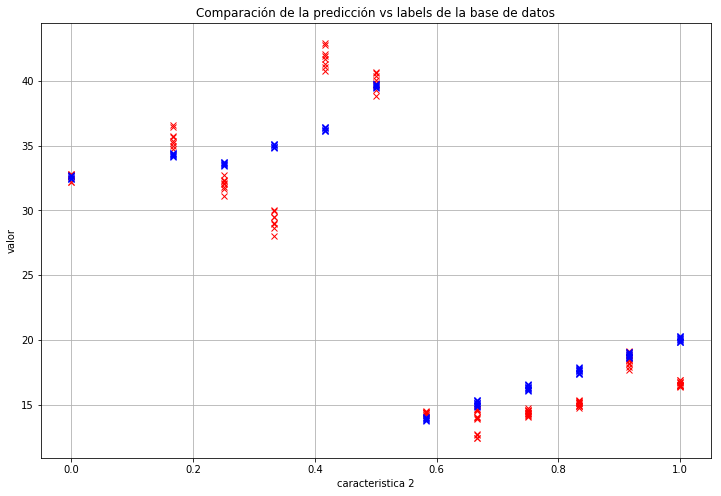

In [40]:
plt.rcParams['figure.figsize'] = (12,8)
plt.grid()
c = 1
plt.plot(X_test[:,c],y_test,'rx')
plt.plot(X_test[:,c],prediction_testing,'bx')
plt.title('Comparación de la predicción vs labels de la base de datos')
plt.xlabel('caracteristica '+ str(c+1))
plt.ylabel('valor')
plt.show()